In [1]:
from src import *
import GPy
import numpy as np
import copy
import torch
import matplotlib
import matplotlib.pyplot as plt

log = simple_logging.getLogger()

In [17]:
utils.init()
x, y = data_source.fetch_data('399106.SZ', 'open')
# np.random.seed(2)
no_points = len(x)
lengthscale = 1
variance = 0
sig_noise = 0.3
k = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=lengthscale)
C = k.K(x, x) + np.eye(no_points) * sig_noise ** 2
# x, y = (x - x.mean()), (y - y.mean())
train_set_count = int(len(x) * 0.8)
train_indices = np.random.randint(len(x), size=train_set_count)
eval_indices = np.setdiff1d(range(len(x)), train_indices)
x_train = x[train_indices]
y_train = y[train_indices]
x_eval = x[eval_indices]
y_eval = y[eval_indices]
x_mean = x_train.mean()
y_mean = y_train.mean()
x_std = x_train.var() ** 0.5
y_std = y_train.var() ** 0.5
x_train = (x_train - x_mean) / x_std
y_train = (y_train - y_mean) / y_std
np.setdiff1d(x, x_train)
num_epochs = 5000
batch_size = nb_train = len(x_train)
learning_rate = 1e-1
mini_batch_size = 10
display_interval = 100
net = models.BBP_Homoscedastic_Model_Wrapper(input_dim=1, output_dim=1, no_units=100, learn_rate=learning_rate,
                                             batch_size=batch_size, no_batches=1, init_log_noise=0)
fit_loss_train = np.zeros(num_epochs)
KL_loss_train = np.zeros(num_epochs)
total_loss = np.zeros(num_epochs)
best_net, best_loss = None, float('inf')
for i in range(num_epochs):
    fit_loss, KL_loss = net.fit(x_train, y_train, no_samples=mini_batch_size)
    fit_loss_train[i] = fit_loss.cpu().data.numpy()
    KL_loss_train[i] = KL_loss.cpu().data.numpy()
    total_loss[i] = fit_loss_train[i] + KL_loss_train[i]
    if fit_loss < best_loss:
        best_loss = fit_loss
        best_net = copy.deepcopy(net.network)
    if i % display_interval == 0 or i == num_epochs - 1:
        log.info("Epoch: %5d/%5d, Fit loss = %8.3f, KL loss = %8.3f, noise = %6.3f" %
                 (i + 1, num_epochs, fit_loss_train[i], KL_loss_train[i],
                  net.network.log_noise.exp().cpu().data.numpy()))

[2020-11-05 21:33:19.539565 I] Program: Initializing
[2020-11-05 21:33:19.541565 I] Program: Using CUDA device GeForce 940MX
[2020-11-05 21:33:19.808565 I] Program: Loaded offline data for 399106.SZ - open
[2020-11-05 21:33:29.185738 I] Program: Epoch:     1/ 5000, Fit loss = 2446.690, KL loss =  339.989, noise =  0.997
[2020-11-05 21:33:35.864732 I] Program: Epoch:   101/ 5000, Fit loss =  106.892, KL loss =  346.930, noise =  0.647
[2020-11-05 21:33:41.304338 I] Program: Epoch:   201/ 5000, Fit loss =  -55.033, KL loss =  353.883, noise =  0.590
[2020-11-05 21:33:45.998331 I] Program: Epoch:   301/ 5000, Fit loss = -452.166, KL loss =  360.256, noise =  0.581
[2020-11-05 21:33:50.601763 I] Program: Epoch:   401/ 5000, Fit loss = -523.707, KL loss =  365.541, noise =  0.545
[2020-11-05 21:33:55.334144 I] Program: Epoch:   501/ 5000, Fit loss = -984.779, KL loss =  370.126, noise =  0.515
[2020-11-05 21:34:00.088139 I] Program: Epoch:   601/ 5000, Fit loss = -1044.789, KL loss =  374.4

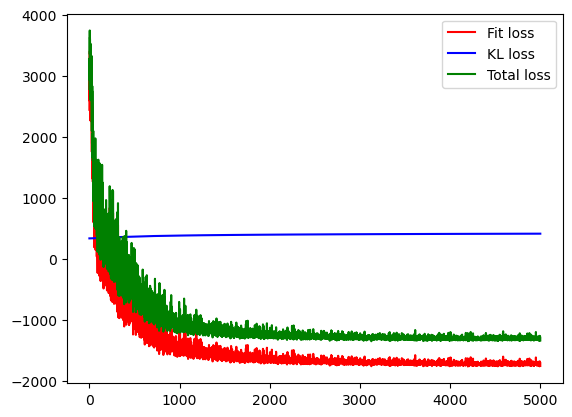

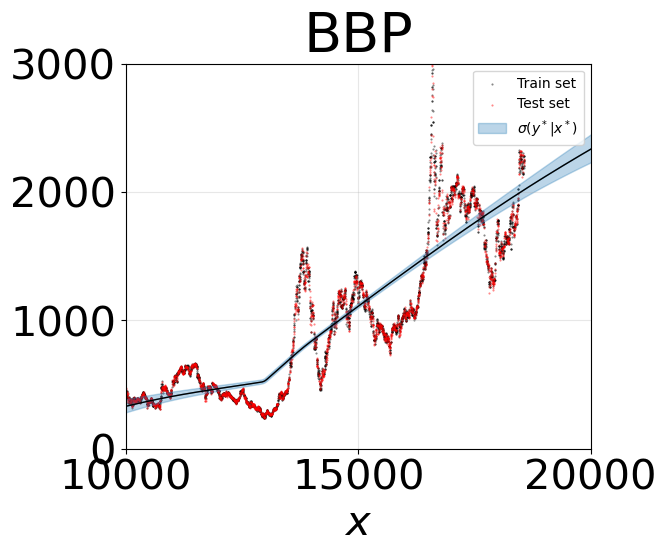

In [18]:
plt.plot(range(num_epochs), fit_loss_train, c='r', label='Fit loss')
plt.plot(range(num_epochs), KL_loss_train, c='b', label='KL loss')
plt.plot(range(num_epochs), total_loss, c='g', label='Total loss')
plt.legend()
plt.show()
sampling_count = 100
sampling_point_num = 10000
sampling_bottom, sampling_top = -5, 5
samples = []
for i in range(sampling_count):
    preds = (best_net.forward(torch.linspace(sampling_bottom, sampling_top, sampling_point_num).cuda())[0] * y_std) + y_mean
    samples.append(preds.cpu().data.numpy()[:, 0])
samples = np.array(samples)
means = samples.mean(axis=0)

aleatoric = best_net.log_noise.exp().cpu().data.numpy()
epistemic = samples.var(axis=0) ** 0.5
total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(6, 5))
plt.style.use('default')
plt.scatter((x_train * x_std) + x_mean, (y_train * y_std) + y_mean, s=1, marker='.', color='black', alpha=0.5, label='Train set')
plt.scatter(x_eval, y_eval, s=1, marker='.', color='red', alpha=0.5, label='Test set')
plt.fill_between(np.linspace(sampling_bottom, sampling_top, sampling_point_num) * x_std + x_mean, means + aleatoric, means + total_unc, color=c[0],
                     alpha=0.3, label=r'$\sigma(y^*|x^*)$')
plt.fill_between(np.linspace(sampling_bottom, sampling_top, sampling_point_num) * x_std + x_mean, means - total_unc, means - aleatoric, color=c[0],
                 alpha=0.3)
# plt.fill_between(np.linspace(sampling_bottom, sampling_top, sampling_point_num) * x_std + x_mean, means - aleatoric, means + aleatoric, color=c[1],
#                  alpha=0.4, label=r'$\EX[\sigma^2]^{1/2}$')

plt.plot(np.linspace(sampling_bottom, sampling_top, sampling_point_num) * x_std + x_mean, means, color='black', linewidth=1)
plt.legend()
plt.xlim([10000, 20000])
plt.ylim([0, 3000])
# plt.ylim(bottom=0)
# plt.ylim([-210, 50])
plt.xlabel('$x$', fontsize=30)
plt.title('BBP', fontsize=40)
plt.tick_params(labelsize=30)
# plt.xticks(np.arange(-4, 5, 2))
# plt.gca().set_yticklabels([])
plt.gca().yaxis.grid(alpha=0.3)
plt.gca().xaxis.grid(alpha=0.3)
plt.savefig('bbp_homo.pdf', bbox_inches='tight')

# files.download("bbp_homo.pdf")

plt.show()

In [ ]:
print(x.max(), x.min(), y.max(), y.min())